### <span style="font-family: Century Gothic">Modelling and Testing (Questionnaire ADHD/Sex Classification)</span>

In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import shap
import tensorflow as tf

<span style="font-family: Century Gothic; font-size:15px">Load Dataset</span>

In [2]:
df = pd.read_excel('Cleaned_Metadata.xlsx')
df.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,PreInt_Demos_Fam_Child_Race_9,PreInt_Demos_Fam_Child_Race_10,PreInt_Demos_Fam_Child_Race_11,MRI_Track_Scan_Location_0,MRI_Track_Scan_Location_1,MRI_Track_Scan_Location_2,MRI_Track_Scan_Location_3,MRI_Track_Scan_Location_4,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,0.825186,-0.059321,-0.567920,0.471031,0.740903,-1.006138,0.671053,0.444049,0.465092,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,-0.883858,1.272741,-0.174889,1,0
1,00fV0OyyoLfw,0.670074,0.300459,-0.567920,-0.316329,-0.700630,1.917403,2.159487,1.203754,1.453973,...,7.192992,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,1,0
2,04X1eiS79T4B,0.557703,0.300459,-0.567920,2.045751,-0.380289,0.056968,1.787378,0.697284,0.465092,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,0,1
3,05ocQutkURd6,0.691545,0.300459,-0.567920,-0.578782,0.420563,-0.740362,0.671053,0.697284,-1.018229,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,0,1
4,06YUNBA9ZRLq,-1.181438,0.300459,3.065452,-0.316329,-0.700630,1.120074,-0.817381,-0.315657,1.948413,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,1,0


In [3]:
df.shape

(1213, 54)

<span style="font-family: Century Gothic; font-size:15px">Checking the null values</span>

In [4]:
assert np.mean(df.isnull().sum()) == 0, "Dataset contains null values!"

<span style="font-family: Century Gothic; font-size:25px">Dataset Summary:</span>

<span style="font-family: Century Gothic; font-size:15px">`1213` samples with `54` features. </span>

<span style="font-family: Century Gothic; font-size:15px"> No missing values, meaning the dataset is fully preprocessed. </span>

<span style="font-family: Century Gothic; font-size:25px"> Target Variables: </span>

<span style="font-family: Century Gothic; font-size:15px"> ADHD_Outcome `0 = No ADHD`, `1 = ADHD`</span>

<span style="font-family: Century Gothic; font-size:15px"> Sex_F `0 = Male`, `1 = Female`</span>

In [5]:
df_model = df.copy()

# <span style="font-family: Century Gothic"> Modelling </span>

In [6]:
# Drop participant ID, extract labels
X = df_model.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F']).values
y_adhd = df_model['ADHD_Outcome'].values
y_sex = df_model['Sex_F'].values

In [7]:
# Split into Train/Validation/Test (60/20/20)

def stratified_split(X, y):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        stratify=y, 
        random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.25, 
        stratify=y_temp, 
        random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
# Train/Test Split
X_train_adhd, X_val_adhd, X_test_adhd, y_train_adhd, y_val_adhd, y_test_adhd = stratified_split(
    X, 
    y_adhd
)

X_train_sex, X_val_sex, X_test_sex, y_train_sex, y_val_sex, y_test_sex = stratified_split(
    X, 
    y_sex
)

<span style="font-family: Century Gothic; font-size:15px"> BIAS MITIGATION for Simple and Intermediate Models

In [9]:
def calculate_class_weight(y_train: pd.Series):
    return dict(
        enumerate(
            compute_class_weight(
                'balanced',
                classes=np.unique(y_train),
                y = y_train
            )
        )
    )

In [10]:
adhd_class_weight = calculate_class_weight(y_train_adhd)
sex_class_weight = calculate_class_weight(y_train_sex)

In [11]:
adhd_class_weight, sex_class_weight

({0: np.float64(1.5873362445414847), 1: np.float64(0.7299196787148594)},
 {0: np.float64(0.7620545073375262), 1: np.float64(1.454)})

In [12]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

<span style="font-family: Century Gothic; font-size:15px"> Model Training Utility

In [13]:
# Train Model

def train_model(model, param_grid, X_train, y_train, X_val, y_val):
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model_ = grid_search.best_estimator_
    
    y_pred = best_model_.predict(X_val)
    y_proba = best_model_.predict_proba(X_val)[:, 1]
    
    print('-----------------------------------------')
    print(f'Best Params: {grid_search.best_params_}')
    print('-----------------------------------------')
    print(classification_report(y_val, y_pred))
    print('-----------------------------------------')
    print(f'ROC AUC Score: {roc_auc_score(y_val, y_proba):.4f}')
    print('-----------------------------------------')
    
    return best_model_

<span style="font-family: Century Gothic; font-size:15px"> Logistic Regression (Simple)

In [14]:
model_ = LogisticRegression(
    class_weight=adhd_class_weight, 
    solver='liblinear'
)

params_lr = {
    'C': [0.01, 0.1, 1, 10]
}

lr_adhd = train_model(
    model_,
    params_lr, 
    X_train_adhd, 
    y_train_adhd, 
    X_val_adhd, 
    y_val_adhd
)

-----------------------------------------
Best Params: {'C': 0.1}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.78      0.66        76
           1       0.88      0.74      0.80       167

    accuracy                           0.75       243
   macro avg       0.73      0.76      0.73       243
weighted avg       0.78      0.75      0.76       243

-----------------------------------------
ROC AUC Score: 0.8152
-----------------------------------------


In [15]:
model_ = LogisticRegression(
    class_weight=sex_class_weight, 
    solver='liblinear'
)

lr_sex = train_model(
    model_,
    params_lr, 
    X_train_sex, 
    y_train_sex, 
    X_val_sex, 
    y_val_sex
)

-----------------------------------------
Best Params: {'C': 0.1}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       160
           1       0.41      0.58      0.48        83

    accuracy                           0.58       243
   macro avg       0.57      0.58      0.56       243
weighted avg       0.62      0.58      0.59       243

-----------------------------------------
ROC AUC Score: 0.6251
-----------------------------------------


<span style="font-family: Century Gothic; font-size:15px"> Random Forest (Intermediate) Model

In [16]:
model_ = RandomForestClassifier(
    class_weight=adhd_class_weight, 
    random_state=42
)

params_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [5, 10, None]
}

rf_adhd = train_model(
    model_,
    params_rf,
    X_train_adhd,
    y_train_adhd,
    X_val_adhd,
    y_val_adhd
)

-----------------------------------------
Best Params: {'max_depth': 5, 'n_estimators': 100}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        76
           1       0.84      0.81      0.83       167

    accuracy                           0.77       243
   macro avg       0.73      0.74      0.74       243
weighted avg       0.78      0.77      0.77       243

-----------------------------------------
ROC AUC Score: 0.8194
-----------------------------------------


In [17]:
model_ = RandomForestClassifier(
    class_weight=sex_class_weight, 
    random_state=42
)

rf_sex = train_model(
    model_,
    params_rf,
    X_train_sex,
    y_train_sex,
    X_val_sex,
    y_val_sex
)

-----------------------------------------
Best Params: {'max_depth': 10, 'n_estimators': 200}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       160
           1       0.48      0.18      0.26        83

    accuracy                           0.65       243
   macro avg       0.58      0.54      0.52       243
weighted avg       0.61      0.65      0.60       243

-----------------------------------------
ROC AUC Score: 0.5872
-----------------------------------------


<span style="font-family: Century Gothic; font-size:15px"> Complex Model

In [18]:
model_ = MLPClassifier(
    max_iter=700, 
    random_state=42
)

params_mlp = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)], 
    'alpha': [0.0001, 0.001]
}


mlp_adhd = train_model(
    model_,
    params_mlp, 
    X_train_adhd, 
    y_train_adhd, 
    X_val_adhd, 
    y_val_adhd
)

-----------------------------------------
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (128,)}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.55      0.55        76
           1       0.79      0.78      0.79       167

    accuracy                           0.71       243
   macro avg       0.67      0.67      0.67       243
weighted avg       0.71      0.71      0.71       243

-----------------------------------------
ROC AUC Score: 0.7551
-----------------------------------------


In [25]:
model_ = MLPClassifier(
    max_iter=700, 
    random_state=42
)

mlp_sex = train_model(
    model_, 
    params_mlp, 
    X_train_sex, 
    y_train_sex, 
    X_val_sex, 
    y_val_sex
)

-----------------------------------------
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (64,)}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       160
           1       0.44      0.39      0.41        83

    accuracy                           0.62       243
   macro avg       0.57      0.56      0.57       243
weighted avg       0.61      0.62      0.62       243

-----------------------------------------
ROC AUC Score: 0.5985
-----------------------------------------


<span style="font-family: Century Gothic; font-size:15px"> Complex Model (Deep Keras)

In [127]:
def build_deep_model(input_dim, lr=0.001, dropout_rate=0.3, metrics='accuracy'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[metrics]
    )
    
    return model

In [27]:
scaler = StandardScaler()
X_train_adhd_scaled = scaler.fit_transform(X_train_adhd)
X_val_adhd_scaled = scaler.transform(X_val_adhd)
X_test_adhd_scaled = scaler.transform(X_test_adhd)

X_train_sex_scaled = scaler.fit_transform(X_train_sex)
X_val_sex_scaled = scaler.fit_transform(X_val_sex)
X_test_sex_scaled = scaler.transform(X_test_sex)

In [28]:
# Checkpoint
adhd_ckpt = 'adhd_que_best_model.keras'
sex_ckpt = 'sex_que_best_model.keras'

In [29]:
# Early Stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath=adhd_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

In [128]:
# Train MLP for ADHD Prediction
deep_mlp_adhd = build_deep_model(X_train_adhd_scaled.shape[1], metrics=tf.keras.metrics.AUC(name='roc_auc'))

deep_mlp_adhd.build()
deep_mlp_adhd.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [110]:
history_adhd = deep_mlp_adhd.fit(
    X_train_adhd_scaled,
    y_train_adhd, 
    epochs=40, 
    batch_size=32, 
    validation_data=(X_val_adhd_scaled, y_val_adhd), 
    callbacks=callbacks,
    verbose=1,
    class_weight=adhd_class_weight
)

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.8914 - roc_auc: 0.5216 - val_loss: 0.6957 - val_roc_auc: 0.7159
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6305 - roc_auc: 0.7474 - val_loss: 0.6454 - val_roc_auc: 0.7649
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6222 - roc_auc: 0.7494 - val_loss: 0.6078 - val_roc_auc: 0.7763
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5524 - roc_auc: 0.8053 - val_loss: 0.5826 - val_roc_auc: 0.7866
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5326 - roc_auc: 0.8187 - val_loss: 0.5719 - val_roc_auc: 0.7874
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5307 - roc_auc: 0.8242 - val_loss: 0.5599 - val_roc_auc: 0.7938
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4927 - roc_auc: 0.8448 - val_loss: 0.5527 - val_roc_auc: 0.7936
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4959 - roc_auc: 0.8371 - val_loss: 0.5535 - val_roc_auc: 0.7956


In [111]:
print(
    "🔹 ADHD ROC AUC Score:", 
    roc_auc_score(
        y_test_adhd, 
        deep_mlp_adhd.predict(X_test_adhd)
    )
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
🔹 ADHD ROC AUC Score: 0.8285088405570333


In [ ]:
def evaluate_final_model(name, model, X_test, y_test, is_keras=False):
    print(f"\n📊 Final Evaluation: {name}")
    if is_keras:
        y_pred = (model.predict(X_test) > 0.6).astype(int)
        y_proba = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
    print(
        "\n🔹 Classification Report:\n", 
        classification_report(y_test, y_pred)
    )
    print(
        "🔹 ROC AUC Score:", 
        roc_auc_score(
            y_test, 
            y_proba
        )
    )

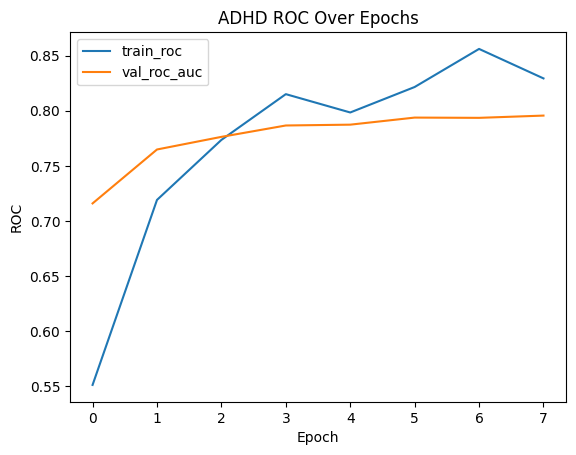

In [112]:
plt.plot(history_adhd.history['roc_auc'], label='train_roc')
plt.plot(history_adhd.history['val_roc_auc'], label = 'val_roc_auc')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.title('ADHD ROC Over Epochs')
plt.legend()
plt.show()

In [113]:
callbacks[1] = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=sex_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

In [135]:
# Train MLP for Sex Classification
deep_mlp_sex = build_deep_model(X_train_sex_scaled.shape[1])

deep_mlp_sex.build()
deep_mlp_sex.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [136]:
history_sex = deep_mlp_sex.fit(
    X_train_sex_scaled, 
    y_train_sex, 
    epochs=40, 
    batch_size=32, 
    validation_data=(X_val_sex_scaled, y_val_sex), 
    callbacks=callbacks,
    verbose=1,
    class_weight=sex_class_weight
)

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4992 - loss: 1.0108 - val_accuracy: 0.5350 - val_loss: 0.7021
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5610 - loss: 0.8360 - val_accuracy: 0.5885 - val_loss: 0.6678
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5582 - loss: 0.8532 - val_accuracy: 0.5967 - val_loss: 0.6637
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6041 - loss: 0.7049 - val_accuracy: 0.6049 - val_loss: 0.6617
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5791 - loss: 0.7647 - val_accuracy: 0.6132 - val_loss: 0.6541
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5912 - loss: 0.7686 - val_accuracy: 0.6214 - val_loss: 0.6592


In [137]:
print(
    "🔹 Sex ROC AUC Score:", 
    roc_auc_score(
        y_test_sex, 
        deep_mlp_sex.predict(X_test_sex)
    )
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
🔹 Sex ROC AUC Score: 0.5539156626506023


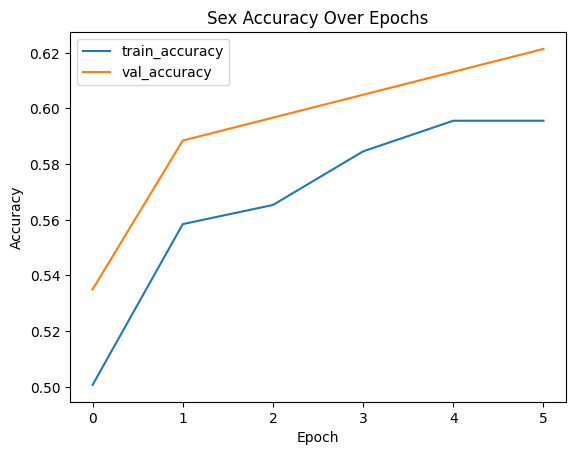

In [138]:
plt.plot(history_sex.history['accuracy'], label='train_accuracy')
plt.plot(history_sex.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Sex Accuracy Over Epochs')
plt.legend()
plt.show()

# <span style="font-family: Century Gothic"> Model Comparison

In [139]:
def calc_cross_val_score(model, x_train, y_train, cv, scoring='accuracy'):
    rf_scores = cross_val_score(
        model, 
        x_train, 
        y_train, 
        cv=cv, 
        scoring=scoring
    )
    
    return np.mean(rf_scores)

In [155]:
cv = 5

rf_adhd_val = calc_cross_val_score(
    rf_adhd,
    X_train_adhd_scaled, 
    y_train_adhd, 
    cv,
    scoring='f1'
)

lr_adhd_val = calc_cross_val_score(
    lr_adhd, 
    X_train_adhd_scaled, 
    y_train_adhd, 
    cv,
    scoring='f1'
)

mlp_adhd_val = calc_cross_val_score(
    mlp_adhd, 
    X_train_adhd_scaled, 
    y_train_adhd, 
    cv,
    scoring='f1'
)

y_pred_adhd = (deep_mlp_adhd.predict(X_test_adhd) > 0.6).astype(int)

deep_adhd_score =  f1_score(
    y_test_adhd, 
    y_pred_adhd
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [156]:
adhd_models = [
    ("Random Forest", rf_adhd, rf_adhd_val),
    ("Logistic Regression", lr_adhd, lr_adhd_val),
    ("MLP", mlp_adhd, mlp_adhd_val),
    ("Deep MLP", deep_mlp_adhd, deep_adhd_score)
]

In [157]:
best_name, adhd_final_model, best_score = max(adhd_models, key=lambda x: x[2])
print(f"✅ Best ADHD Model: {best_name} with score {best_score:.4f}")

✅ Best ADHD Model: Random Forest with score 0.8428


In [158]:
evaluate_final_model(
    best_name, 
    adhd_final_model, 
    X_test_adhd_scaled,
    y_test_adhd,
    is_keras=("Deep" in best_name)
)


📊 Final Evaluation: Random Forest

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.66      0.67        77
           1       0.84      0.85      0.85       166

    accuracy                           0.79       243
   macro avg       0.76      0.76      0.76       243
weighted avg       0.79      0.79      0.79       243

🔹 ROC AUC Score: 0.8357064622124862


In [148]:
cv = 5

rf_sex_val = calc_cross_val_score(
    rf_sex,
    X_train_sex, 
    y_train_sex, 
    cv
)

lr_sex_val = calc_cross_val_score(
    lr_sex, 
    X_train_sex, 
    y_train_sex, 
    cv
)

mlp_sex_val = calc_cross_val_score(
    mlp_sex, 
    X_train_sex, 
    y_train_sex, 
    cv
)

deep_sex_score = history_sex.history['val_accuracy'][-1]

In [141]:
sex_models = [
    ("Random Forest", rf_sex, rf_sex_val),
    ("Logistic Regression", lr_sex, lr_sex_val),
    ("MLP", mlp_sex, mlp_sex_val),
    ("Deep MLP", deep_mlp_sex, deep_sex_score)
]

In [149]:
best_name_, sex_final_model, best_score_ = max(sex_models, key=lambda x: x[2])
print(f"✅ Best Sex Model: {best_name_} with score {best_score_:.4f}")

✅ Best Sex Model: Random Forest with score 0.6589


In [143]:
evaluate_final_model(
    best_name_, 
    sex_final_model, 
    X_test_sex_scaled,
    y_test_sex,
    is_keras=("Deep" in best_name)
)


📊 Final Evaluation: Random Forest

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.91      0.78       160
           1       0.55      0.20      0.30        83

    accuracy                           0.67       243
   macro avg       0.62      0.56      0.54       243
weighted avg       0.64      0.67      0.62       243

🔹 ROC AUC Score: 0.6191265060240964


<span style="font-family: Century Gothic"> 🧠 ADHD Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> The Random Forest model demonstrates solid performance in classifying ADHD outcomes. With an overall `accuracy` of `79%` and a `ROC AUC` score of `0.84`, the model shows a strong ability to distinguish between `ADHD-positive` and `ADHD-negative` cases.</span>

<span style="font-family: Century Gothic; font-size: 15px">The `F1-score` of `0.85` for `class 1` (likely ADHD-positive) indicates high precision and recall, making the model especially reliable for detecting individuals with ADHD.</span>

<span style="font-family: Century Gothic; font-size: 15px">Although the `F1-score` for `class 0` (likely non-ADHD) is slightly lower at `0.67`, the model still maintains balanced performance with a macro average `F1-score of 0.76`.</span>

<span style="font-family: Century Gothic; font-size: 15px">The `ROC AUC` score of `0.84` further confirms that the model effectively separates the two classes across all thresholds.
</span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: Overall, `Random Forest` proves to be a robust choice for ADHD classification, especially when prioritizing accurate detection of `ADHD-positive` individuals. </span>

<span style="font-family: Century Gothic"> 🧬 Sex Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> The Random Forest model shows limited effectiveness in classifying biological sex based on the given features.</span>

<span style="font-family: Century Gothic; font-size: 15px">While it achieves an overall `accuracy` of `67%`, the performance is heavily skewed toward classifying `class 0` (likely Male), with a `recall` of `91%` and an `F1-score`of `0.78`.</span>

<span style="font-family: Century Gothic; font-size: 15px">However, for `class 1` (likely Female), the model struggles significantly, with a `recall` of just `20%` and a low `F1-score` of `0.30`, indicating poor sensitivity and higher false negatives.</span>

<span style="font-family: Century Gothic; font-size: 15px">The `ROC AUC` score of `0.62` suggests the model's discriminatory power is weak and only slightly better than random guessing.
</span>

<span style="font-family: Century Gothic; font-size: 15px">In summary, while the `Random Forest model` handles the majority class (Male) reasonably well, it performs poorly in identifying the minority class (Female), highlighting issues with class imbalance or insufficient feature representation for sex differentiation. Additional feature engineering, data balancing techniques or a different model architecture may be needed to improve results.</span>

# <span style="font-family: Century Gothic"> SHAP EXPLAINABILITY

In [79]:
X = df_model.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
feature_names = X.columns.tolist()

In [88]:
def shap_explainer(model, train, sample):
    explainer = shap.LinearExplainer(model, train) if isinstance(model, LogisticRegression) else shap.TreeExplainer(model)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, feature_names)

In [89]:
def shap_neural_network(model, train, sample):
    data = shap.sample(train, 100, random_state=42)
    explainer = shap.Explainer(model.predict_proba, data)
    values = explainer.shap_values(sample[:10])

    shap.summary_plot(values, sample[:10], feature_names)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23616\2358897175.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, feature_names)


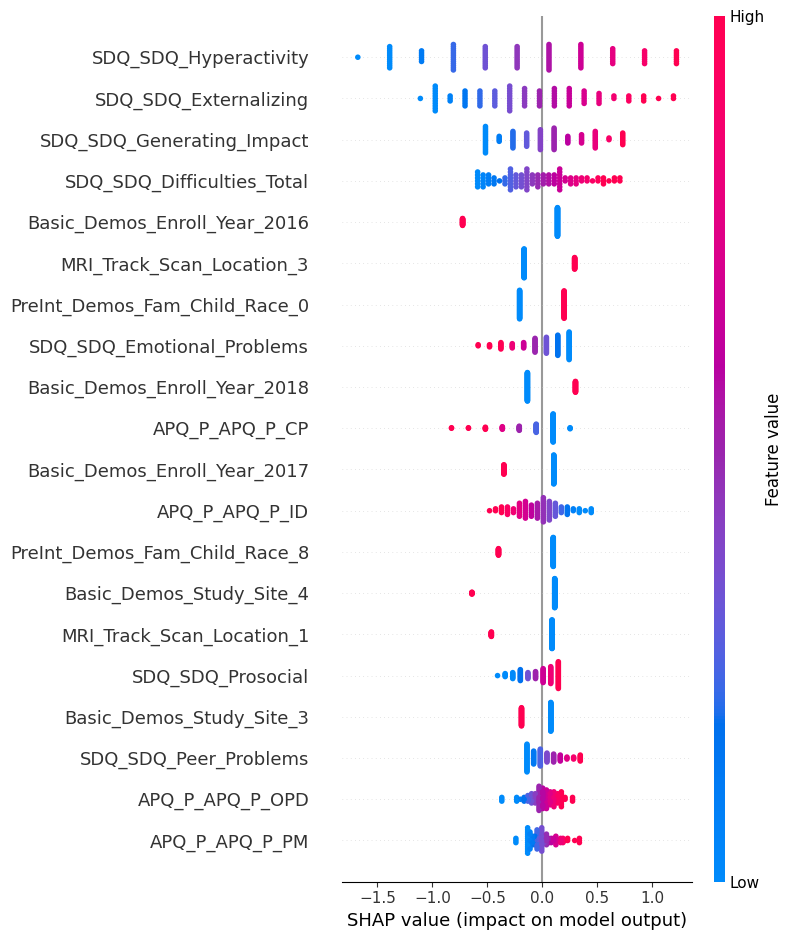

In [90]:
shap_explainer(
    lr_adhd, 
    X_train_adhd, 
    X_val_adhd[:100]
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23616\2358897175.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, feature_names)


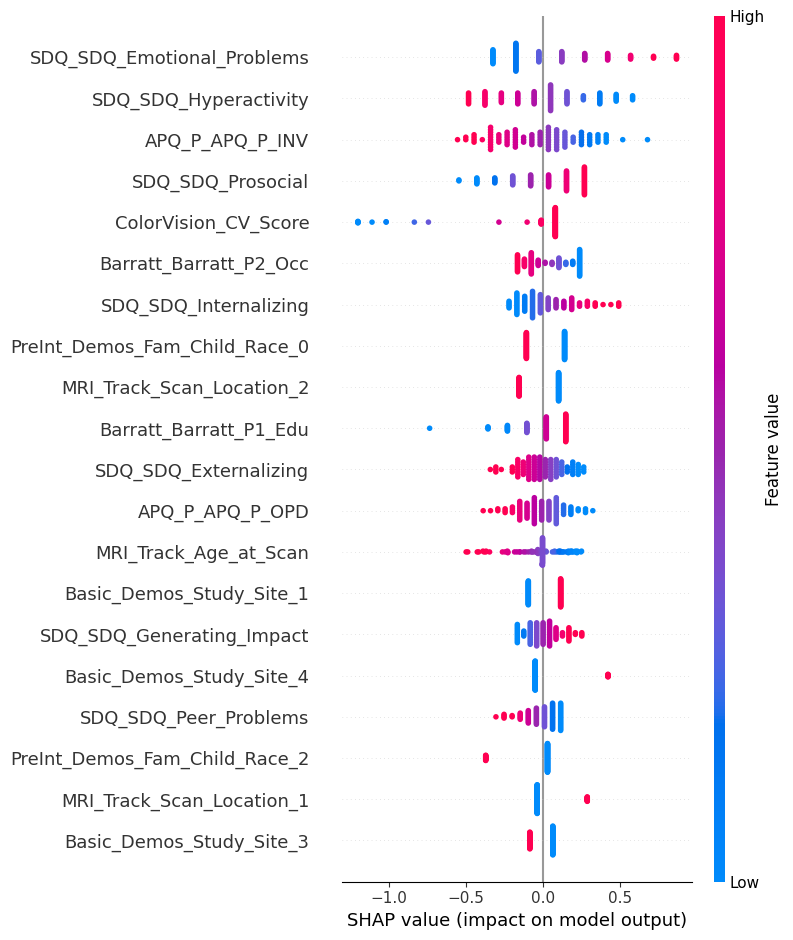

In [91]:
shap_explainer(
    lr_sex, 
    X_train_sex, 
    X_val_sex[:100]
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23616\2358897175.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, feature_names)
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  sum

<Figure size 640x480 with 0 Axes>

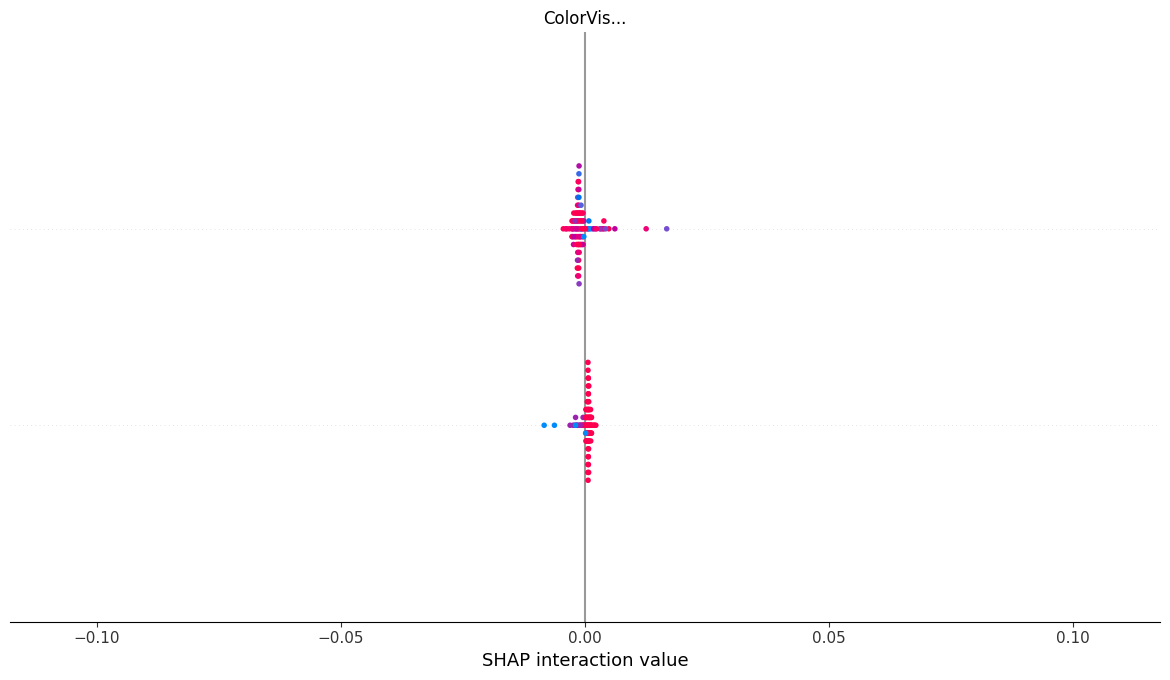

In [94]:
shap_explainer(
    rf_adhd,
    X_train_adhd,
    X_val_adhd[:100]
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23616\2358897175.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, feature_names)
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  sum

<Figure size 640x480 with 0 Axes>

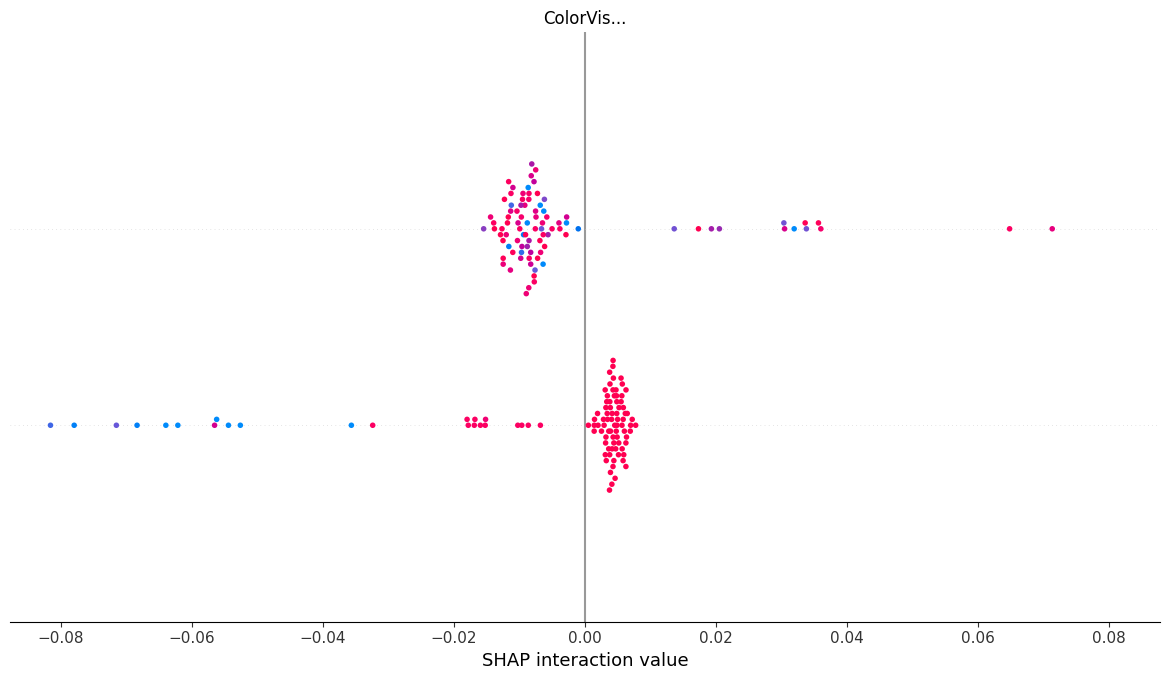

In [93]:
shap_explainer(
    rf_sex,
    X_train_sex,
    X_val_sex[:100]
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23616\3470583899.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, sample[:10], feature_names)
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  sum

<Figure size 640x480 with 0 Axes>

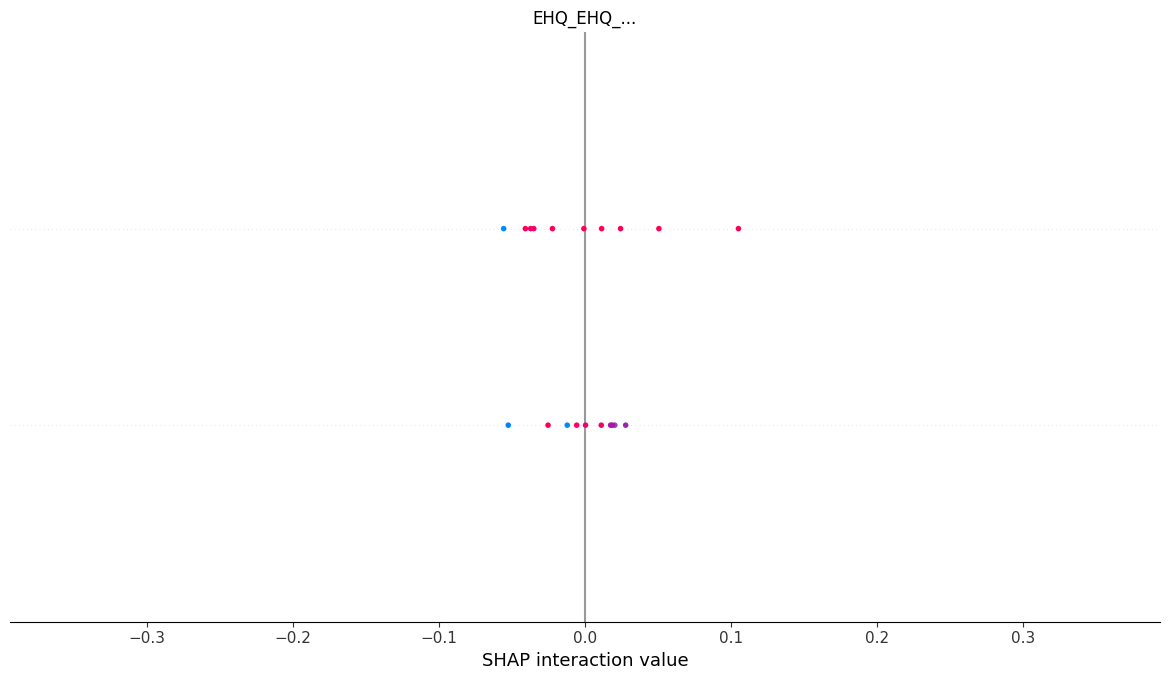

In [95]:
shap_neural_network(
    mlp_adhd,
    X_train_adhd,
    X_val_adhd[:100]
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23616\3470583899.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, sample[:10], feature_names)
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  sum

<Figure size 640x480 with 0 Axes>

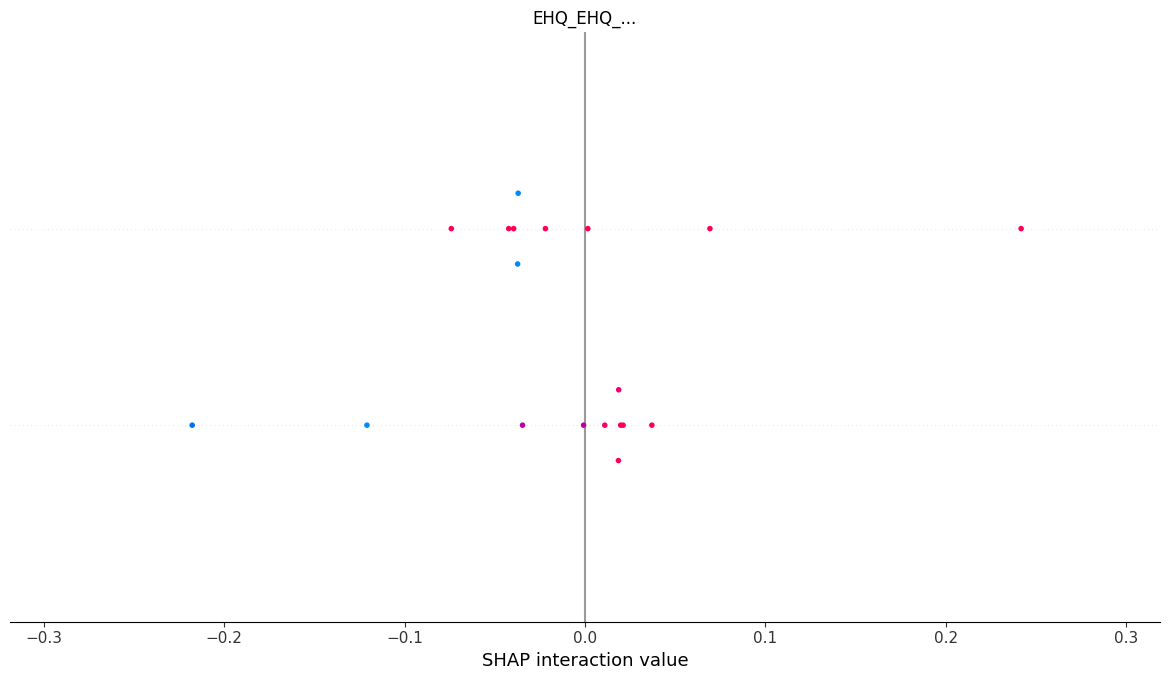

In [96]:
shap_neural_network(
    mlp_sex,
    X_train_sex,
    X_val_sex[:100]
)